In [250]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, Column, join, MaskedColumn
from astropy import units as u
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import time

In [251]:
sample = Table.read('Gr8stars_GaiaeDR3_TIC_hires.csv')
sample.sort(['_RAJ2000','_DEJ2000'])

In [252]:
table = sample['_RAJ2000', '_DEJ2000']
table.rename_column('_RAJ2000', 'ra_j2000')
table.rename_column('_DEJ2000', 'dec_j2000')

In [253]:
# names:
table['primary_name'] = sample['EDR3Name'] # overwritten later
table['gaiadr2_source_id'] = sample['GAIA']
table['gaiaedr3_source_id'] = sample['Source']
table['hip'] = sample['HIP']
table.add_column(Column(name='hd', dtype='<U29', length=len(table)))
table['tic'] = sample['TIC']
table['2mass'] = sample['2MASS']
table['wisea'] = sample['WISEA']

In [254]:
# gaia:
table['ra'] = sample['RA_ICRS']
table['ra_error'] = sample['e_RA_ICRS']
table['dec'] = sample['DE_ICRS']
table['dec_error'] = sample['e_DE_ICRS']
table['parallax'] = sample['Plx']
table['parallax_error'] = sample['e_Plx']
table['pmra'] = sample['pmRA']
table['pmra_error'] = sample['e_pmRA']
table['pmdec'] = sample['pmDE']
table['pmdec_error'] = sample['e_pmDE']
table['gmag'] = sample['Gmag']
table['bp_rp'] = sample['BPRP']
table['radial_velocity'] = sample['RVDR2']
table['radial_velocity_error'] = sample['e_RVDR2']
table['ref_epoch'] = 'J2016.0'

### add SIMBAD alternative identifiers:

In [139]:
# correct some failed matches by hand (ugh):
# for most of these the TIC x-match failed, therefore SIMBAD does not include the TIC ID
# in three cases there is no Gaia DR2 ID so HIP, 2MASS, WISEA must also be copied as SIMBAD query on DR2 ID will fail
table['tic'][table['gaiaedr3_source_id'] == 411413822074322432] = 252191219
table['gaiadr2_source_id'][table['gaiaedr3_source_id'] == 411413822074322432] = 411413822074322432
table['tic'][table['gaiaedr3_source_id'] == 883596170039715072] = 101637926
table['gaiadr2_source_id'][table['gaiaedr3_source_id'] == 883596170039715072] = 883596170039715072
table['tic'][table['gaiaedr3_source_id'] == 1030087329727496320] = 459753450
table['hip'][table['gaiaedr3_source_id'] == 1030087329727496320] = 43630  # from TIC
table['2mass'][table['gaiaedr3_source_id'] == 1030087329727496320] = '08530805+5457112'  # from TIC
table['wisea'][table['gaiaedr3_source_id'] == 1030087329727496320] = 'J085308.10+545711.5'  # from TIC
table['tic'][table['gaiaedr3_source_id'] == 3890250298609911168] = 63189338
table['hip'][table['gaiaedr3_source_id'] == 3890250298609911168] = 51145  # from TIC
table['2mass'][table['gaiaedr3_source_id'] == 3890250298609911168] = '10265302+1713099'  # from TIC
table['wisea'][table['gaiaedr3_source_id'] == 3890250298609911168] = 'J102652.99+171309.1'  # from TIC
table['tic'][table['gaiaedr3_source_id'] == 762815470562110464] = 166646191 # this one is ALSO TIC 353969903
table['hip'][table['gaiaedr3_source_id'] == 762815470562110464] = 54035  # from TIC
table['2mass'][table['gaiaedr3_source_id'] == 762815470562110464] = '11032027+3558203'  # from TIC
table['wisea'][table['gaiaedr3_source_id'] == 762815470562110464] = 'J110319.67+355722.4'  # from SIMBAD
table['tic'][table['gaiaedr3_source_id'] == 778947814402602752] = 252803603
table['gaiadr2_source_id'][table['gaiaedr3_source_id'] == 778947814402602752] = 778947814402405120
table['tic'][table['gaiaedr3_source_id'] == 4445793563751403264] = 276883893 # magnitude changed considerably DR2 to eDR3 hence failed checks but seems ok to me
table['gaiadr2_source_id'][table['gaiaedr3_source_id'] == 4445793563751403264] = 4445793563749783424
table['tic'][table['gaiaedr3_source_id'] == 4468557611984384512] = 398120047
table['gaiadr2_source_id'][table['gaiaedr3_source_id'] == 4468557611984384512] = 4468557611977678336

In [11]:
# more failed matches by hand:
# these all have correct TIC x-match but TIC and DR2 IDs are not ingested properly in SIMBAD
# so we'll query on an alternative identifier
weird_ones_map = {'Gaia DR2 386648181647057152':'HD 225291A',
                 'Gaia DR2 2551241944269355776': 'HD 3972A',
                 'Gaia DR2 417565761431676288': 'HIP 3585',
                 'Gaia DR2 2572433347264096768': 'HIP 8110',
                 'Gaia DR2 90783037268826368': 'HIP 9434',  # bright double
                 'Gaia DR2 139281533098990336': 'HD 19771',  # bright double
                 'Gaia DR2 450345089271313536': 'HD 21903',  # bright double
                 'Gaia DR2 2989285658784560640': 'HIP 23951',  # bright double
                 'Gaia DR2 3235618049144649984': 'HD 33866',
                 'Gaia DR2 3319596479531147392': 'HD 38767',  # bright double
                 'Gaia DR2 3049638303010222080': 'HD 52590',
                 'Gaia DR2 901953203859813888': 'HD 67501A',  # co-moving twin pair?
                 'Gaia DR2 901953199567368960': 'HD 67501B',  # co-moving twin pair?
                 'Gaia DR2 903616971110812544': 'HD 71974',  # bright double
                 'Gaia DR2 811174736439695232': 'HD 80441', # bright double
                 'Gaia DR2 3850860191466194688': 'HD 82267',
                 'Gaia DR2 1070274204844445056': 'HIP 49230',
                 'Gaia DR2 746691643641649536': 'HIP 49315',
                 'Gaia DR2 4022691525057422208': 'HIP 56054',
                 'Gaia DR2 1466569467151572992': 'HD 114723',  # bright double ?
                 'Gaia DR2 1603382317472430080': 'HIP 71109',
                 'Gaia DR2 1186325496788069632': 'HD 131473',  # bright double
                 'Gaia DR2 4409032079673958528': 'HIP 78024',
                 'Gaia DR2 1191393008443719808': 'TYC 956-1098-1',  # HD 143597. no survey other than Tycho and Gaia resolves them
                 'Gaia DR2 1191393008441035648': 'TYC 956-1098-2',  # HD 143597
                 'Gaia DR2 4148904396147803136': 'HD 162739',  # duplicated in TIC as TIC 207281346
                 'Gaia DR2 4185205008718146048': 'HD 179518',  # this HD is TIC as 6990809 with a different DR2 ID but no Gaia info, diff V mag ??
                 'Gaia DR2 4516054074788081152': 'HD 180054',  # duplicated in TIC as TIC 352587633
                 'Gaia DR2 2087620020176419072': 'HIP 99388',
                 'Gaia DR2 1804783160869679872': 'HIP 101315',
                 'Gaia DR2 1731257443928035200': 'HIP 104047',
                 'Gaia DR2 1787693589076214016': 'HD 205160B',  # associated twin stars w slightly different PMRA?
                 'Gaia DR2 1787693589076213632': 'HD 205160A',  # associated twin stars w slightly different PMRA?
                 'Gaia DR2 2681975358571981312': 'HD 209965',  # bright double
                 'Gaia DR2 1929623635232510208': 'HIP 112722',
                 'Gaia DR2 2643881159024617088': 'HIP 115891'}

In [8]:
# primary name:

simbad_failed = []
maybe_double = []
for i,t in enumerate(table):
    if i%5 == 0:
        time.sleep(0.5) # wait 0.5 s to avoid borking simbad
    if i%100 == 0:
        print('{0}/{1} complete'.format(i,len(table)))
    name = 'Gaia DR2 '+str(t['gaiadr2_source_id'])
    if name in weird_ones_map:
        result = Simbad.query_objectids(weird_ones_map[name])
    else:
        result = Simbad.query_objectids(name)
    if result is None:
        simbad_failed.append(t['primary_name'])
        continue
    for r in result:
        if 'HIP' in r[0]:
            if table['hip'][i] != int(r[0].split()[1]): # TESS x-match fail
                #print('WARNING: replacing ID HIP {0} with HIP {1} for row {2}'.format(table['hip'][i],
                #        r[0].split()[1], i))
                table['hip'][i] = r[0].split()[1]
        elif ('HD ' in r[0]):
            table['hd'][i] = r[0].split()[1]
        elif 'WISEA' in r[0]:
            if table['wisea'][i] != r[0].split()[1] or table['wisea'].mask[i]: # TESS x-match fail
                table['wisea'][i] = r[0].split()[1]
        elif '2MASS' in r[0]:
            if (table['2mass'][i] != r[0].split()[1][1:]) or table['2mass'].mask[i]: # TESS x-match fail
                table['2mass'][i] = r[0].split()[1][1:] # clip off the initial J for consistency
    # set primary names:
    for r in result:
        if r[0][:2] == '**':
            maybe_double.append(t['primary_name'])
        elif r[0][0] == '*':
            table['primary_name'][i] = r[0][1:].strip() # string magic
            continue # take only the first * name  
    if table['primary_name'][i][0:4] == 'Gaia':
        if table['hd'][i] != '':
            table['primary_name'][i] = 'HD'+table['hd'][i]
        elif table['hip'][i] > -1:
            table['primary_name'][i] = 'HIP'+str(table['hip'][i])

0/2858 complete
100/2858 complete
200/2858 complete
300/2858 complete
400/2858 complete
500/2858 complete
600/2858 complete
700/2858 complete
800/2858 complete
900/2858 complete
1000/2858 complete
1100/2858 complete


/Users/mbedell/opt/miniconda3/envs/gr8stars/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): 'Gaia DR2 -1' this identifier has an incorrect format for catalogs: 	Gaia : Gaia 	Gaia (
  (error.line, error.msg))


1200/2858 complete
1300/2858 complete
1400/2858 complete
1500/2858 complete
1600/2858 complete
1700/2858 complete
1800/2858 complete
1900/2858 complete
2000/2858 complete
2100/2858 complete
2200/2858 complete
2300/2858 complete
2400/2858 complete
2500/2858 complete
2600/2858 complete
2700/2858 complete
2800/2858 complete


In [9]:
simbad_failed = np.array(simbad_failed)
maybe_double = np.unique(maybe_double)

print(len(simbad_failed), len(maybe_double))

3 705


In [10]:
table.write('Gr8stars_GaiaeDR3_formatted-names.csv', overwrite=True)

### skip to here to avoid re-running SIMBAD queries:

In [255]:
# hacky alternative to rerunning all the simbad code:
table2 = Table.read('Gr8stars_GaiaeDR3_formatted-names.csv')
table2.sort(['ra_j2000','dec_j2000'])
table['hd'] = table2['hd']
table['primary_name'] = table2['primary_name']
table['hip'] = table2['hip']
table['2mass'] = table2['2mass']
table['wisea'] = table2['wisea']

In [256]:
table['tic'] = MaskedColumn(table['tic'], mask=(table['tic'] <= 0))

In [257]:
table['hip'] = MaskedColumn(table['hip'], mask=(table['hip'] <= 0))

In [258]:
# HD, 2MASS, WISE are already masked; Gaia eDR3 has no values that need masking

In [259]:
table[0:10]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7
0.1735187163099,62.1758995053047,HD224792,429915991435184000,429915991435184000,58,224792,417860263,00004167+6210331,J000041.58+621032.9,0.17307161161,0.0135,62.17570631925,0.0153,26.1048,0.0182,-46.955,0.017,-43.467,0.019,6.922204,0.67424,3.76,0.27,J2016.0
0.2923327649201,-0.0761104076889,HD224839,2546019543207725440,2546019543207725440,93,224839,138684373,00011015-0004338,J000110.18-000434.6,0.29252029523,0.0274,-0.07639817491,0.0198,15.7099,0.0311,42.194,0.038,-64.748,0.019,7.981884,0.764665,-3.02,0.16,J2016.0
0.4571711894795,65.4555699380329,HD224919,432197890377254528,432197890377254528,--,224919,418988281,00014974+6527200,J000149.74+652720.6,0.45736153541,0.0117,65.45580468513,0.012,15.3692,0.0151,17.791,0.015,52.818,0.016,7.535949,0.631671,-29.18,0.15,J2016.0
0.5431196625046,27.0818330846237,85 Peg,2853900872207150720,2853900872207888768,171,224930,611726941,00021014+2704570,J000210.87+270444.6,0.54669605643,0.2633,27.07764869795,0.2213,81.179,0.449,716.46,0.452,-941.497,0.242,5.595876,0.929018,-35.57,0.35,J2016.0
0.6965612550145,2.1301527341538,HD225028A,2739059700184753280,2739059700184753280,--,225028A,611064061,--,--,0.69683851342,0.0193,2.12973783087,0.0154,23.3713,0.0233,62.34,0.028,-93.353,0.015,7.213268,0.799183,-2.54,0.19,J2016.0
0.8580574171151,20.6655286255845,HD225097,2846469822870413696,2846469822870413696,276,225097,238301314,00032593+2039561,J000325.97+203954.3,0.85833620764,0.144,20.66483347784,0.185,14.5756,0.225,58.692,0.187,-156.408,0.236,7.341593,0.79231,-31.51,0.4,J2016.0
1.2346725514673,23.2696293916025,HD225261,2848150288954631296,2848150288954631296,400,225261,258866681,00045634+2316106,J000456.61+231610.6,1.23652388841,0.0188,23.26959631737,0.0219,37.9297,0.0258,382.667,0.024,-7.444,0.029,7.624367,0.940167,7.51,0.16,J2016.0
1.2396804613202,45.6737925276659,HD225291A,386648181647057152,386648181647057152,404,225291A,439946040,00045752+4540257,J000457.52+454025.5,1.23979666771,0.0154,45.67350137279,0.012,13.6393,0.0222,18.27,0.019,-65.51,0.016,7.438472,0.694592,-17.15,0.16,J2016.0
1.3798428459156,-9.6174575097273,HD63,2428706669045383808,2428706669045383808,462,63,176285709,00053115-0937028,J000531.22-093703.7,1.38022917866,0.0325,-9.61779490682,0.0212,20.1669,0.036,85.703,0.041,-75.914,0.024,7.020907,0.603799,0.44,0.31,J2016.0


In [260]:
table[table['tic'].mask]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7
17.0679289393636,54.9201558892397,mu. Cas,-1,411413822074322432,5336,6582,--,01081597+5455148,J010820.48+545456.6,17.0947498612,0.2806,54.91320397756,0.289,130.2881,0.4348,3468.251,0.354,-1564.844,0.365,4.948012,0.922226,-96.93,0.18,J2016.0
108.2042589779048,27.2250609982939,HD55130B,-1,883596170039715072,--,55130B,--,--,--,108.20437524491,0.5852,27.22457430182,0.6333,21.541,0.6483,23.262,0.676,-109.507,0.594,7.095436,0.592942,nan,nan,J2016.0
133.2834891086175,54.9530587118437,Gaia EDR3 1030087329727496320,-1,1030087329727496320,43630,--,--,08530805+5457112,J085308.10+545711.5,133.28379071561,0.114,54.95326950556,0.1023,19.6785,0.1727,38.969,0.124,47.429,0.124,7.932846,0.761742,nan,nan,J2016.0
156.7208595697895,17.219443631006,Gaia EDR3 3890250298609911168,-1,3890250298609911168,51145,--,--,10265302+1713099,J102652.99+171309.1,156.72064700312,0.173,17.21915548179,0.1591,11.513,0.2158,-45.684,0.205,-64.834,0.133,7.794488,0.61961,nan,nan,J2016.0
165.8341450816425,35.9698822727936,Gaia EDR3 762815470562110464,-1,762815470562110464,54035,--,--,11032027+3558203,J110319.67+355722.4,165.83095967578,0.0241,35.94865303266,0.0294,392.7529,0.0321,-580.057,0.026,-4776.589,0.03,6.551172,2.215609,nan,nan,J2016.0
166.3690706208598,43.5267741524225,HIP54211,-1,778947814402602752,54211,--,--,11052903+4331357,J110524.36+433146.2,166.34205974427,0.0247,43.53094856108,0.0244,203.8876,0.0332,-4406.469,0.031,938.527,0.028,7.912665,2.104178,nan,nan,J2016.0
252.780917368212,9.4041205614543,HD152113,-1,4445793563751403264,82460,152113,--,16510741+0924154,--,252.7810032285,0.0833,9.40356705738,0.0445,15.2509,0.1196,19.059,0.117,-124.538,0.083,7.905127,0.692442,nan,nan,J2016.0
271.3635350549962,2.5001462819313,70 Oph A,-1,4468557611984384512,--,165341A,--,--,--,271.36445381846,0.142,2.49522409591,0.135,195.5674,0.1964,206.525,0.246,-1107.492,0.164,3.987364,1.003693,nan,nan,J2016.0


### add Gaia DR2:

In [261]:
# gaia DR2:
table['primary_name','gaiadr2_source_id'].write('gaiadr2.vot', format='votable', overwrite=True)  # write out the DR2 source_ids
#Gaia.ROW_LIMIT = 5000
query = "SELECT TOP 5000 * FROM tap_upload.tbl AS tbl, gaiadr2.gaia_source AS gaia WHERE tbl.gaiadr2_source_id=gaia.source_id"
j = Gaia.launch_job(query=query, upload_resource='gaiadr2.vot', 
                    upload_table_name="tbl", verbose=True)
r = j.get_results()

Launched query: 'SELECT TOP 5000 * FROM tap_upload.tbl AS tbl, gaiadr2.gaia_source AS gaia WHERE tbl.gaiadr2_source_id=gaia.source_id'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/sync
Content-type = multipart/form-data; boundary====1691697472357===
200 200
[('Date', 'Thu, 10 Aug 2023 19:57:52 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=12BDB7589E98065FAFDFB67B67BF1182; Path=/tap-server; Secure; HttpOnly'), ('Content-Encoding', 'gzip'), ('Content-Disposition', 'attachment;filename="1691697472808O-result.vot"'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'application/x-votable+xml')]
Retrieving sync. results...
Query finished.


In [262]:
r.columns

<TableColumns names=('primary_name','gaiadr2_source_id','solution_id','DESIGNATION','source_id','random_index','ref_epoch','ra','ra_error','dec','dec_error','parallax','parallax_error','parallax_over_error','pmra','pmra_error','pmdec','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr','astrometric_n_obs_al','astrometric_n_obs_ac','astrometric_n_good_obs_al','astrometric_n_bad_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved','astrometric_primary_flag','astrometric_weight_al','astrometric_pseudo_colour','astrometric_pseudo_colour_error','mean_varpi_factor_al','astrometric_matched_observations','visibility_periods_used','astrometric_sigma5d_max','frame_rotator_object_type','matched_observations','duplicated_source','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_fl

In [263]:
dr2_table = r['gaiadr2_source_id', 'teff_val']
dr2_table.rename_column('teff_val', 'gaia_teff')
dr2_table['gaia_teff_lower'] = r['teff_percentile_lower']
dr2_table['gaia_teff_upper'] = r['teff_percentile_upper']
dr2_table['gaia_radius'] = r['radius_val']
dr2_table['gaia_radius_lower'] = r['radius_percentile_lower']
dr2_table['gaia_radius_upper'] = r['radius_percentile_upper']
dr2_table['gaia_lum'] = r['lum_val']
dr2_table['gaia_lum_lower'] = r['lum_percentile_lower']
dr2_table['gaia_lum_upper'] = r['lum_percentile_upper']

In [267]:
table_with_dr2 = join(table, dr2_table, keys='gaiadr2_source_id', join_type='left')

In [268]:
assert len(table_with_dr2) == len(table)

In [269]:
table_with_dr2.sort(['ra_j2000','dec_j2000']) # get it in the same order as sample
for i in np.random.randint(0,len(table),42):
    assert table[i]['gaiadr2_source_id'] == table_with_dr2[i]['gaiadr2_source_id']

In [270]:
table = table_with_dr2

In [271]:
# we had to preserve -1 IDs because table join doesn't like joining on masked columns, 
# but let's mask them now:
table['gaiadr2_source_id'] = MaskedColumn(table['gaiadr2_source_id'], 
                                          mask=(table['gaiadr2_source_id'] <= 0))

In [272]:
table[table['tic'].mask]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32
17.0679289393636,54.9201558892397,mu. Cas,--,411413822074322432,5336,6582,--,01081597+5455148,J010820.48+545456.6,17.0947498612,0.2806,54.91320397756,0.289,130.2881,0.4348,3468.251,0.354,-1564.844,0.365,4.948012,0.922226,-96.93,0.18,J2016.0,--,--,--,--,--,--,--,--,--
108.2042589779048,27.2250609982939,HD55130B,--,883596170039715072,--,55130B,--,--,--,108.20437524491,0.5852,27.22457430182,0.6333,21.541,0.6483,23.262,0.676,-109.507,0.594,7.095436,0.592942,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--
133.2834891086175,54.9530587118437,Gaia EDR3 1030087329727496320,--,1030087329727496320,43630,--,--,08530805+5457112,J085308.10+545711.5,133.28379071561,0.114,54.95326950556,0.1023,19.6785,0.1727,38.969,0.124,47.429,0.124,7.932846,0.761742,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--
156.7208595697895,17.219443631006,Gaia EDR3 3890250298609911168,--,3890250298609911168,51145,--,--,10265302+1713099,J102652.99+171309.1,156.72064700312,0.173,17.21915548179,0.1591,11.513,0.2158,-45.684,0.205,-64.834,0.133,7.794488,0.61961,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--
165.8341450816425,35.9698822727936,Gaia EDR3 762815470562110464,--,762815470562110464,54035,--,--,11032027+3558203,J110319.67+355722.4,165.83095967578,0.0241,35.94865303266,0.0294,392.7529,0.0321,-580.057,0.026,-4776.589,0.03,6.551172,2.215609,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--
166.3690706208598,43.5267741524225,HIP54211,--,778947814402602752,54211,--,--,11052903+4331357,J110524.36+433146.2,166.34205974427,0.0247,43.53094856108,0.0244,203.8876,0.0332,-4406.469,0.031,938.527,0.028,7.912665,2.104178,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--
252.780917368212,9.4041205614543,HD152113,--,4445793563751403264,82460,152113,--,16510741+0924154,--,252.7810032285,0.0833,9.40356705738,0.0445,15.2509,0.1196,19.059,0.117,-124.538,0.083,7.905127,0.692442,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--
271.3635350549962,2.5001462819313,70 Oph A,--,4468557611984384512,--,165341A,--,--,--,271.36445381846,0.142,2.49522409591,0.135,195.5674,0.1964,206.525,0.246,-1107.492,0.164,3.987364,1.003693,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--


### add hires info:

In [273]:
table.add_column(Column(name='spectrum_hires', dtype='<U29', length=len(table)))

In [274]:
# grab relevant info from sample:
hires_table = Table()
hires_table.add_column(Column(name='gaiaedr3_source_id', dtype=np.int64, length=len(sample)))
for i,s in enumerate(sample['EDR3Name']):
    hires_table[i]['gaiaedr3_source_id'] = s.split()[2] # hack relying on spaces
hires_table['spectrum_hires_resolution'] = MaskedColumn(sample['hires_maxres'], 
                                                  mask=(sample['hires_maxres'] == 0))
hires_table['spectrum_hires_nobs'] = MaskedColumn(sample['n_hires_obs_maxres_iodout'], 
                                            mask=(sample['n_hires_obs_maxres_iodout'] == 0))
hires_table['spectrum_hires_snr'] = MaskedColumn(sample['hires_maxres_snr'], 
                                           mask=(sample['hires_maxres_snr'] == 0))

In [275]:
table_with_hires = join(table, hires_table, keys='gaiaedr3_source_id', join_type='left')

In [276]:
table_with_hires['spectrum_hires'][~table_with_hires['spectrum_hires_snr'].mask] = 'true'

In [277]:
table = table_with_hires

### add harps info:

In [278]:
harps_table = Table.read('annelies/Gr8_spectra_info_HARPS.txt', format='ascii', comment='-')

In [279]:
harps_table.rename_column('Name', 'primary_name')
harps_table.rename_column('S2D HARPS', 'spectrum_harps_nobs')
harps_table.rename_column('SNR co-added HARPS', 'spectrum_harps_snr')

In [280]:
harps_table[harps_table['spectrum_harps_nobs'] == 0]

primary_name,spectrum_harps_nobs,spectrum_harps_snr
str9,int64,float64
9 Cet,0,427.1
HD7449,0,158.5
HD26334,0,112.6
HD54351,0,288.3
rho Cnc,0,221.8
HD82106,0,140.4
HD97658,0,125.7
HD116941,0,133.4
HD117126,0,335.1


In [281]:
table.add_column(Column(name='spectrum_harps', dtype='<U29', length=len(table)))

In [282]:
table_with_harps = join(table, harps_table, keys='primary_name', join_type='left')

In [283]:
table_with_harps['spectrum_harps_nobs'].fill_value = 0
table_with_harps['spectrum_harps_snr'].fill_value = 0.

In [284]:
table_with_harps['spectrum_harps'][(table_with_harps['spectrum_harps_snr'] > 0) 
                                   & ~(table_with_harps['spectrum_harps_snr'].mask)] = 'true'

In [285]:
np.sum(table_with_harps['spectrum_harps'] == 'true')

350

In [286]:
table = table_with_harps

### add sophie info:

In [287]:
sophie_table = Table.read('annelies/Gr8_spectra_info_SOPHIE.txt', format='ascii', comment='-')

In [288]:
sophie_table.rename_column('Name', 'primary_name')
sophie_table.rename_column('S2D SOPHIE', 'spectrum_sophie_nobs')
sophie_table.rename_column('SNR co-added SOPHIE', 'spectrum_sophie_snr')

In [289]:
np.sum(sophie_table['spectrum_sophie_nobs'] == 0)

0

In [290]:
table.add_column(Column(name='spectrum_sophie', dtype='<U29', length=len(table)))
table_with_sophie = join(table, sophie_table, keys='primary_name', join_type='left')

In [291]:
table_with_sophie['spectrum_sophie_nobs'].fill_value = 0
table_with_sophie['spectrum_sophie_snr'].fill_value = 0.

In [292]:
table_with_sophie['spectrum_sophie'][(table_with_sophie['spectrum_sophie_nobs'] > 0) 
                                   & ~(table_with_sophie['spectrum_sophie_nobs'].mask)] = 'true'

In [293]:
table = table_with_sophie

### add hermes info:

In [294]:
#hermes_table = Table.read('hermes/hermes_spectra.txt', format='ascii', names=['filename'], data_end=-1)

In [295]:
hermes_table = Table.read('hermes/Gr8_spectra_info_HERMES.txt', format='ascii', delimiter='\t')[1:]['Name', 'SNR co-added HERMES']

In [296]:
hermes_table.rename_column('Name', 'primary_name')
hermes_table.rename_column('SNR co-added HERMES', 'spectrum_hermes_snr')

In [297]:
hermes_table['primary_name'] = Column(hermes_table['primary_name'], dtype='<U29')

In [298]:
hermes_table['spectrum_hermes_nobs'] = np.zeros(len(hermes_table), dtype=int) + 1

In [299]:
just_hermes = join(table, hermes_table, keys='primary_name', join_type='right')
just_hermes[just_hermes['ra_j2000'].mask]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str18,int64
--,--,BD+17_2463,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,171.8668753821042,1
--,--,HD101501,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,204.0674299308931,1
--,--,HD10476,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,120.5668081318515,1
--,--,HD157214,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,192.929747039328,1
--,--,HD72905,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,155.8124566341522,1
--,--,HD82885,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,193.1870708971247,1
--,--,HD86728,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,201.3739743508217,1


In [300]:
just_hermes[0:10]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str18,int64
--,--,BD+17_2463,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,171.8668753821042,1
174.1487189852519,56.1353543141282,HD100831A,844865117036623232,844865117036623232,56622,100831A,137729151,11363571+5608074,J113635.47+560806.2,174.1472877129,0.0108,56.13494946936,0.0121,21.1416,0.0165,-179.449,0.014,-91.092,0.016,7.555699,0.801509,-15.8,0.19,J2016.0,5813.0,5757.0,5875.0,1.2488316,1.2226124,1.2732453,1.6043674,1.600464,1.6082708,,--,--,--,,--,--,,--,--,124.6904974628892,1
--,--,HD101501,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,204.0674299308931,1
176.4532410527907,6.9426191565085,HD102211,3909855690445677696,3909855690445677696,57378,102211,396936263,11454877+0656335,J114548.68+065633.6,176.45265359911,0.0243,6.94266722055,0.0192,15.5794,0.029,-131.208,0.028,10.814,0.023,7.580417,0.60091,-15.84,0.29,J2016.0,6264.85,6144.1,6482.0,1.431613,1.3373003,1.4884369,2.844387,2.8292606,2.8595135,,--,--,--,,--,--,,--,--,161.3455547566396,1
--,--,HD10476,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,120.5668081318515,1
181.5246349942624,49.1584234653053,HD105123,1546708987054162560,1546708987054162560,59024,105123,53551449,12060594+4909303,J120605.77+490930.3,181.52377057058,0.009,49.15845341494,0.0114,17.2377,0.0176,-127.194,0.01,6.738,0.013,7.584469,0.645386,2.06,0.19,J2016.0,6336.6665,6249.0,6475.3003,1.2681192,1.2144005,1.3039494,2.3359218,2.328396,2.3434474,,--,--,--,,--,--,,--,--,177.5860020323029,1
185.5714579938443,3.2976961550299,HD107658,3701522323158628608,3701522323158628608,60337,107658,377189813,12221716+0317515,J122217.05+031751.9,185.57081704943,0.0256,3.29775265995,0.0181,15.5122,0.0283,-143.974,0.032,12.714,0.025,7.879244,0.647258,-14.54,0.2,J2016.0,6281.0,6064.4,6424.5,1.244863,1.1898727,1.3353758,2.1729667,2.161794,2.1841395,,--,--,--,,--,--,,--,--,118.4409781823015,1
26.936810149498,63.8525030572972,HD10780,512167948043650816,512167948043650816,8362,10780,373694425,01474488+6351090,J014745.79+635108.1,26.94267663258,0.0255,63.85140778825,0.029,99.5902,0.0438,581.684,0.032,-246.462,0.037,5.410397,0.971028,2.67,0.13,J2016.0,5350.0,5304.0,5783.5,0.86252683,0.7380719,0.87755257,0.5491046,0.54837245,0.5498367,true,71600.0,1,100.0,,--,--,true,38,398.9,190.5318404412456,1


In [301]:
# correct the primary name on bad matches:
hermes_table['primary_name'][hermes_table['primary_name'] == 'BD+17_2463'] = 'Gaia EDR3 3946449911319493504'
hermes_table['primary_name'][hermes_table['primary_name'] == 'HD101501'] = '61 UMa'
hermes_table['primary_name'][hermes_table['primary_name'] == 'HD10476'] = '2 Ari'
hermes_table['primary_name'][hermes_table['primary_name'] == 'HD157214'] = '72 Her'
hermes_table['primary_name'][hermes_table['primary_name'] == 'HD72905'] = 'pi.01 UMa'
hermes_table['primary_name'][hermes_table['primary_name'] == 'HD82885'] = '11 LMi'
hermes_table['primary_name'][hermes_table['primary_name'] == 'HD86728'] = '20 LMi'

In [302]:
just_hermes = join(table, hermes_table, keys='primary_name', join_type='right')
just_hermes[0:10]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str18,int64
143.9145924739025,35.8101325142152,11 LMi,798068905726303232,798068905726303232,47080,82885,8915802,09353959+3548366,J093538.92+354834.4,143.91061083593,0.0692,35.80898121341,0.0601,89.0092,0.0937,-726.514,0.07,-259.057,0.062,5.200431,0.934127,14.39,0.17,J2016.0,5661.0,5488.0,6794.75,0.93610704,0.64977777,0.99605566,0.8108086,0.8083409,0.8132763,true,71600.0,1,95.0,,--,--,,--,--,193.1870708971247,1
25.6240105213668,20.2685126826973,2 Ari,96331172942614528,96331172942614528,7981,10476,113710966,01422977+2016073,J014229.55+201559.7,25.62258568628,0.1209,20.26551918226,0.0906,130.8234,0.1532,-300.737,0.137,-673.539,0.106,4.99968,1.022485,-33.58,0.17,J2016.0,5489.3335,5063.5,6576.0,0.74435675,0.5186767,0.87482005,0.45324752,0.45170915,0.45478588,true,102700.0,5,315.2919282189127,,--,--,,--,--,120.5668081318515,1
150.2527369843307,31.9236702818993,20 LMi,746545172372256384,746545172372256384,49081,86728,172954294,10010072+3155262,J100100.21+315520.6,150.24996758591,0.0697,31.92176197568,0.0648,66.9958,0.0921,-528.871,0.092,-429.376,0.074,5.204957,0.840548,56.01,0.17,J2016.0,5832.0,5625.0,6082.75,1.1615477,1.0677563,1.2486106,1.4061733,1.4004412,1.4119055,true,71600.0,4,116.17658972443631,,--,--,,--,--,201.3739743508217,1
175.2625677942549,34.2016337792914,61 UMa,4025850731201819392,4025850731201819392,56997,101501,101641846,11410301+3412064,J114103.01+341201.9,175.26250050618,0.0681,34.19993957544,0.0986,104.4252,0.1005,-12.522,0.088,-381.196,0.142,5.110995,0.906035,-5.6,0.41,J2016.0,5573.6665,5488.0,5787.0,0.8599333,0.79770035,0.88698965,0.6429663,0.6413257,0.6446068,true,71600.0,1,84.0,,--,--,,--,--,204.0674299308931,1
260.1648643743331,32.4677438774612,72 Her,1333760419707327744,1333760419707327744,84862,157214,9728611,17203955+3228056,J172039.69+322753.3,260.16557980211,0.0427,32.46311742251,0.0461,68.5575,0.0553,135.81,0.058,-1040.953,0.054,5.209875,0.820611,-78.43,0.16,J2016.0,5830.0,5734.6665,6022.25,1.1306806,1.0596427,1.168586,1.3306038,1.327499,1.3337086,true,102700.0,5,193.67240381634136,,--,--,,--,--,192.929747039328,1
184.9548648891468,16.8085244139832,Gaia EDR3 3946449911319493504,3946449911319493504,3946449911319493504,--,--,72416873,12194916+1648308,J121949.18+164829.2,184.95493702648,0.0225,16.8079021021,0.019,18.3528,0.0266,15.537,0.03,-140.02,0.024,7.742777,0.831325,22.13,0.15,J2016.0,5740.5,5690.0,5802.3335,1.363087,1.3341899,1.3873898,1.8177776,1.8103718,1.8251835,,--,--,--,,--,--,,--,--,171.8668753821042,1
174.1487189852519,56.1353543141282,HD100831A,844865117036623232,844865117036623232,56622,100831A,137729151,11363571+5608074,J113635.47+560806.2,174.1472877129,0.0108,56.13494946936,0.0121,21.1416,0.0165,-179.449,0.014,-91.092,0.016,7.555699,0.801509,-15.8,0.19,J2016.0,5813.0,5757.0,5875.0,1.2488316,1.2226124,1.2732453,1.6043674,1.600464,1.6082708,,--,--,--,,--,--,,--,--,124.6904974628892,1
176.4532410527907,6.9426191565085,HD102211,3909855690445677696,3909855690445677696,57378,102211,396936263,11454877+0656335,J114

In [303]:
table.add_column(Column(name='spectrum_hermes', dtype='<U29', length=len(table)))
table_with_hermes = join(table, hermes_table, keys='primary_name', join_type='left')

In [304]:
table_with_hermes['spectrum_hermes_nobs'].fill_value = 0
table_with_hermes['spectrum_hermes_snr'].fill_value = 0.

In [305]:
table_with_hermes['spectrum_hermes'][(table_with_hermes['spectrum_hermes_nobs'] > 0) 
                                   & ~(table_with_hermes['spectrum_hermes_nobs'].mask)] = 'true'

In [306]:
table_with_hermes[table_with_hermes['hd']  == '86728']

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str29,str18,int64
150.2527369843307,31.9236702818993,20 LMi,746545172372256384,746545172372256384,49081,86728,172954294,10010072+3155262,J100100.21+315520.6,150.24996758591,0.0697,31.92176197568,0.0648,66.9958,0.0921,-528.871,0.092,-429.376,0.074,5.204957,0.840548,56.01,0.17,J2016.0,5832.0,5625.0,6082.75,1.1615477,1.0677563,1.2486106,1.4061733,1.4004412,1.4119055,true,71600.0,4,116.17658972443631,,--,--,,--,--,true,201.3739743508217,1


In [307]:
table_with_hermes[table_with_hermes['spectrum_hermes'] == 'true']

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str29,str18,int64
143.9145924739025,35.8101325142152,11 LMi,798068905726303232,798068905726303232,47080,82885,8915802,09353959+3548366,J093538.92+354834.4,143.91061083593,0.0692,35.80898121341,0.0601,89.0092,0.0937,-726.514,0.07,-259.057,0.062,5.200431,0.934127,14.39,0.17,J2016.0,5661.0,5488.0,6794.75,0.93610704,0.64977777,0.99605566,0.8108086,0.8083409,0.8132763,true,71600.0,1,95.0,,--,--,,--,--,true,193.1870708971247,1
25.6240105213668,20.2685126826973,2 Ari,96331172942614528,96331172942614528,7981,10476,113710966,01422977+2016073,J014229.55+201559.7,25.62258568628,0.1209,20.26551918226,0.0906,130.8234,0.1532,-300.737,0.137,-673.539,0.106,4.99968,1.022485,-33.58,0.17,J2016.0,5489.3335,5063.5,6576.0,0.74435675,0.5186767,0.87482005,0.45324752,0.45170915,0.45478588,true,102700.0,5,315.2919282189127,,--,--,,--,--,true,120.5668081318515,1
150.2527369843307,31.9236702818993,20 LMi,746545172372256384,746545172372256384,49081,86728,172954294,10010072+3155262,J100100.21+315520.6,150.24996758591,0.0697,31.92176197568,0.0648,66.9958,0.0921,-528.871,0.092,-429.376,0.074,5.204957,0.840548,56.01,0.17,J2016.0,5832.0,5625.0,6082.75,1.1615477,1.0677563,1.2486106,1.4061733,1.4004412,1.4119055,true,71600.0,4,116.17658972443631,,--,--,,--,--,true,201.3739743508217,1
175.2625677942549,34.2016337792914,61 UMa,4025850731201819392,4025850731201819392,56997,101501,101641846,11410301+3412064,J114103.01+341201.9,175.26250050618,0.0681,34.19993957544,0.0986,104.4252,0.1005,-12.522,0.088,-381.196,0.142,5.110995,0.906035,-5.6,0.41,J2016.0,5573.6665,5488.0,5787.0,0.8599333,0.79770035,0.88698965,0.6429663,0.6413257,0.6446068,true,71600.0,1,84.0,,--,--,,--,--,true,204.0674299308931,1
260.1648643743331,32.4677438774612,72 Her,1333760419707327744,1333760419707327744,84862,157214,9728611,17203955+3228056,J172039.69+322753.3,260.16557980211,0.0427,32.46311742251,0.0461,68.5575,0.0553,135.81,0.058,-1040.953,0.054,5.209875,0.820611,-78.43,0.16,J2016.0,5830.0,5734.6665,6022.25,1.1306806,1.0596427,1.168586,1.3306038,1.327499,1.3337086,true,102700.0,5,193.67240381634136,,--,--,,--,--,true,192.929747039328,1
184.9548648891468,16.8085244139832,Gaia EDR3 3946449911319493504,3946449911319493504,3946449911319493504,--,--,72416873,12194916+1648308,J121949.18+164829.2,184.95493702648,0.0225,16.8079021021,0.019,18.3528,0.0266,15.537,0.03,-140.02,0.024,7.742777,0.831325,22.13,0.15,J2016.0,5740.5,5690.0,5802.3335,1.363087,1.3341899,1.3873898,1.8177776,1.8103718,1.8251835,,--,--,--,,--,--,,--,--,true,171.8668753821042,1
174.1487189852519,56.1353543141282,HD100831A,844865117036623232,844865117036623232,56622,100831A,137729151,11363571+5608074,J113635.47+560806.2,174.1472877129,0.0108,56.13494946936,0.0121,21.1416,0.0165,-179.449,0.014,-91.092,0.016,7.555699,0.801509,-15.8,0.19,J2016.0,5813.0,5757.0,5875.0,1.2488316,1.2226124,1.2732453,1.6043674,1.600464,1.6082708,,--,--,--,,--,--,,--,--,true,124.6904974628892,1
176.4532410527907,6.9426191565085,HD102211,3909855690445677696,390985

In [308]:
table = table_with_hermes

### write it out:

In [309]:
table[table['hd']  == '209779']

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str29,str18,int64
331.5220948604787,-5.3581640115525,HD209779,2621051110038749440,2621051110039687936,109110,209779,2024277731,22060532-0521291,--,331.52288038903,0.0542,-5.35835702703,0.0548,27.4355,0.065,175.972,0.073,-43.428,0.073,7.406189,0.861938,-11.31,0.63,J2016.0,5700.6665,5659.25,5729.75,1.070933,1.0600888,1.0866653,1.091244,1.0882074,1.0942806,,--,--,--,true,5,236.5,,--,--,,--,--


In [310]:
table[table['tic'].mask]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes,spectrum_hermes_snr,spectrum_hermes_nobs
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,solRad,solRad,solRad,solLum,solLum,solLum,,,,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64,str29,str18,int64
271.3635350549962,2.5001462819313,70 Oph A,--,4468557611984384512,--,165341A,--,--,--,271.36445381846,0.142,2.49522409591,0.135,195.5674,0.1964,206.525,0.246,-1107.492,0.164,3.987364,1.003693,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,true,29,253.2,,--,--,,--,--
133.2834891086175,54.9530587118437,Gaia EDR3 1030087329727496320,--,1030087329727496320,43630,--,--,08530805+5457112,J085308.10+545711.5,133.28379071561,0.114,54.95326950556,0.1023,19.6785,0.1727,38.969,0.124,47.429,0.124,7.932846,0.761742,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--
156.7208595697895,17.219443631006,Gaia EDR3 3890250298609911168,--,3890250298609911168,51145,--,--,10265302+1713099,J102652.99+171309.1,156.72064700312,0.173,17.21915548179,0.1591,11.513,0.2158,-45.684,0.205,-64.834,0.133,7.794488,0.61961,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--
165.8341450816425,35.9698822727936,Gaia EDR3 762815470562110464,--,762815470562110464,54035,--,--,11032027+3558203,J110319.67+355722.4,165.83095967578,0.0241,35.94865303266,0.0294,392.7529,0.0321,-580.057,0.026,-4776.589,0.03,6.551172,2.215609,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--
252.780917368212,9.4041205614543,HD152113,--,4445793563751403264,82460,152113,--,16510741+0924154,--,252.7810032285,0.0833,9.40356705738,0.0445,15.2509,0.1196,19.059,0.117,-124.538,0.083,7.905127,0.692442,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--
108.2042589779048,27.2250609982939,HD55130B,--,883596170039715072,--,55130B,--,--,--,108.20437524491,0.5852,27.22457430182,0.6333,21.541,0.6483,23.262,0.676,-109.507,0.594,7.095436,0.592942,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--
166.3690706208598,43.5267741524225,HIP54211,--,778947814402602752,54211,--,--,11052903+4331357,J110524.36+433146.2,166.34205974427,0.0247,43.53094856108,0.0244,203.8876,0.0332,-4406.469,0.031,938.527,0.028,7.912665,2.104178,nan,nan,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--
17.0679289393636,54.9201558892397,mu. Cas,--,411413822074322432,5336,6582,--,01081597+5455148,J010820.48+545456.6,17.0947498612,0.2806,54.91320397756,0.289,130.2881,0.4348,3468.251,0.354,-1564.844,0.365,4.948012,0.922226,-96.93,0.18,J2016.0,--,--,--,--,--,--,--,--,--,,--,--,--,,--,--,,--,--,,--,--


In [311]:
from astropy.io import ascii
ascii.write(table, 'Gr8stars_GaiaeDR3_formatted.csv', delimiter=',', formats={'spectrum_hires_snr':'%.1f'},
           comment=False, overwrite=True)

### subsets with and without good spectra:

In [312]:
table = Table.read('Gr8stars_GaiaeDR3_formatted.csv')

In [315]:
table[0:10]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_hermes,spectrum_hermes_snr,spectrum_hermes_nobs
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,int64,float64,str4,int64,float64,str4,int64,float64,str4,float64,int64
238.1689210400862,42.4515174680292,1 Her,1384195086792268800,1384195086792268800,77760,142373,157364190,15524052+4227052,J155240.95+422712.1,238.17156439238,0.0608,42.45431545672,0.0739,62.9028,0.0807,438.839,0.08,629.541,0.099,4.424265,0.784468,-56.01,0.16,J2016.0,6073.0,5888.5,6158.0,1.6416836977005005,1.5966756343841553,1.7461707592010498,3.3028345108032227,3.2885117530822754,3.31715726852417,--,--,--,--,--,--,--,--,--,--,--,--,--
126.1458923835362,-3.7512424989997,1 Hya,3066710282611675776,3066710282611675776,41211,70958,168975758,08243502-0345045,J082434.89-034504.6,126.14494794137,0.045,-3.75135791807,0.032,36.9674,0.061,-212.044,0.06,-25.969,0.059,5.468879,0.648508,96.87,5.64,J2016.0,6320.5,6246.0,6395.0,1.5511353015899658,1.5152051448822021,1.5883586406707764,3.4593920707702637,3.446709156036377,3.4720749855041504,--,--,--,--,--,--,--,--,--,--,--,--,--
191.2475206828197,39.2789161469845,10 CVn,1521686782461765888,1521686782461765888,62207,110897,389853353,12445938+3916441,--,191.24545542461,0.0197,39.27953401499,0.0174,56.9588,0.0323,-359.699,0.018,139.016,0.018,5.803025,0.756415,80.45,0.19,J2016.0,5967.75,5926.5,6026.33349609375,0.9827778339385986,0.9637630581855774,0.9965062141418457,1.1036920547485352,1.1017658710479736,1.1056182384490967,true,102700.0,3,139.8,--,--,--,--,--,--,--,--,--
54.2182654350701,0.4016644716193,10 Tau,3263836568393943808,3263836568394170880,16852,22484,649766486,03365238+0024054,J033652.23+002400.9,54.21723179469,0.1306,0.39952459488,0.1093,71.837,0.1503,-232.563,0.164,-481.472,0.143,4.141093,0.757795,nan,nan,J2016.0,6082.33349609375,5830.0,6164.66650390625,--,--,--,--,--,--,true,71600.0,2,151.4,--,--,--,--,--,--,--,--,--
74.9346751253041,15.9167324100169,101 Tau,3393284752392701312,3393284752392701312,23214,31845,389121767,04594432+1555002,J045944.38+155459.9,74.93506827868,0.0241,15.91660060912,0.0127,22.3771,0.0262,85.068,0.033,-29.655,0.021,6.644502,0.59449,41.72,0.54,J2016.0,6520.25,6444.5,6551.5,1.4123555421829224,1.3989139795303345,1.4457528591156006,3.2481775283813477,3.2326443195343018,3.2637107372283936,--,--,--,--,true,1,123.5,--,--,--,--,--,--
76.8625232015097,18.6450499366847,104 Tau,3407611182744289152,3407611182744289152,23835,32923,27136704,05072692+1838420,--,76.86503115411,0.0897,18.64513194789,0.0566,62.8252,0.1094,534.674,0.111,18.449,0.083,4.732457,0.844065,20.58,0.15,J2016.0,5835.0,5700.0,6022.0,1.5503768920898438,1.4555847644805908,1.6246854066848755,2.510340929031372,2.4968111515045166,2.5238707065582275,true,71600.0,3,196.4,true,48,597.9,--,--,--,--,--,--
315.1410034667797,-4.7302596237905,11 Aqr,6912276699251278848,6912276699251278848,103682,199960,248854510,21003382-0443486,J210033.85-044350.1,315.1412210745,0.0209,-4.73087375776,0.0137,36.9971,0.0293,48.795,0.028,-138.18,0.021,6.063653,0.779556,-17.34,0.14,J2016.0,5920.0,5863.0,5967.0,1.3689217567443848,1.347441554069519,1.395668387413025,2.0736658573150635,2.0693469047546387,2.0779848098754883,true,71600.0,1,86.0,true,77,596.6,--,--,--,--,--,--
143.9145924739025,35.8101325142152,11 L

In [3]:
mag_cut = (table['gmag'] <= 7.5)

good_harps = ((table['spectrum_harps_snr'] > 100) & (table['spectrum_harps'] == 'true') & mag_cut)
ok_harps = ((table['spectrum_harps_snr'] <= 100) & (table['spectrum_harps'] == 'true') & mag_cut)
print('HARPS: {0} good spectra, {1} ok spectra'.format(np.sum(good_harps), np.sum(ok_harps)))

HARPS: 190 good spectra, 13 ok spectra


In [4]:
good_sophie = ((table['spectrum_sophie_snr'] > 100) & (table['spectrum_sophie'] == 'true') & mag_cut)
ok_sophie = ((table['spectrum_sophie_snr'] <= 100) & (table['spectrum_sophie'] == 'true') & mag_cut)
print('SOPHIE: {0} good spectra, {1} ok spectra'.format(np.sum(good_sophie), np.sum(ok_sophie)))

SOPHIE: 500 good spectra, 137 ok spectra


In [5]:
good_hires = (table['spectrum_hires_snr'] > 100)  & mag_cut
ok_hires = (table['spectrum_hires_snr'] > 0) & (table['spectrum_hires'] == 'true') & mag_cut
print('HIRES: {0} good spectra, {1} ok spectra'.format(np.sum(good_hires), np.sum(ok_hires)))

HIRES: 212 good spectra, 335 ok spectra


In [6]:
good_spectra_table = table[good_harps | good_sophie]# | good_hires]
print('{0} stars with good (SNR>100) spectra'.format(len(good_spectra_table)))

623 stars with good (SNR>100) spectra


In [7]:
no_spectra = (table['spectrum_harps'] != "true") & (table['spectrum_sophie'] != "true") & mag_cut # (table['spectrum_hires'] != "true") & mag_cut
no_spectra_table = table[no_spectra]
print('{0} stars without any spectra'.format(len(no_spectra_table)))

663 stars without any spectra


In [8]:
1237 - 1099

138

In [9]:
ok_spectra_table = table[~no_spectra & ~good_harps & ~good_sophie & ~good_hires & mag_cut]
print('{0} stars with only ok spectra'.format(len(ok_spectra_table)))

118 stars with only ok spectra


In [10]:
ascii.write(good_spectra_table, 'targets_with_spectra.csv', delimiter=',', formats={'spectrum_hires_snr':'%.1f'},
           comment=False, overwrite=True)

AttributeError: 'builtin_function_or_method' object has no attribute 'write'

In [10]:
from astropy.io import ascii
ascii.write(no_spectra_table, 'targets_need_spectra.csv', delimiter=',', formats={'spectrum_hires_snr':'%.1f'},
           comment=False, overwrite=True)

In [49]:
ascii.write(ok_spectra_table, 'targets_want_spectra.csv', delimiter=',', formats={'spectrum_hires_snr':'%.1f'},
           comment=False, overwrite=True)

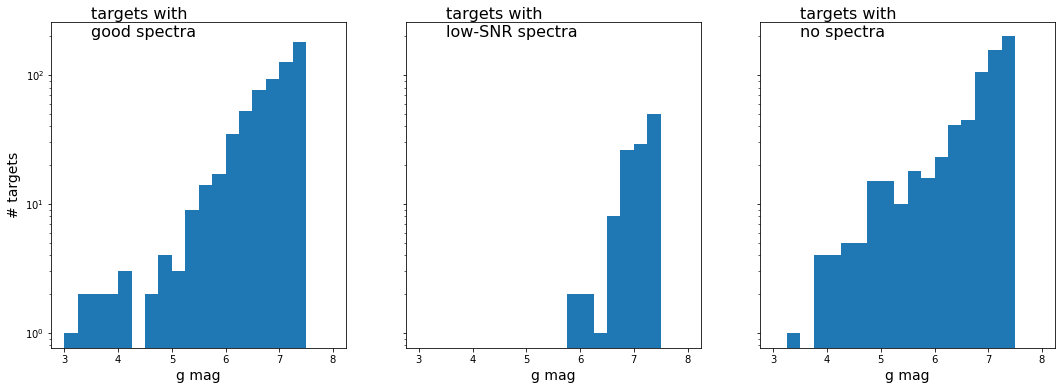

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6), sharey=True, sharex=True)
bins = np.arange(3,8.25,0.25)
ax1.hist(good_spectra_table['gmag'], bins=bins)
ax1.text(3.5, 200, 'targets with\ngood spectra', fontsize=16)
ax1.set_yscale('log')
ax1.set_ylabel('# targets', fontsize=14)
ax1.set_xlabel('g mag', fontsize=14)
ax2.hist(ok_spectra_table['gmag'], bins=bins)
ax2.text(3.5, 200, 'targets with\nlow-SNR spectra', fontsize=16)
ax2.set_xlabel('g mag', fontsize=14)
ax3.hist(no_spectra_table['gmag'], bins=bins)
ax3.text(3.5, 200, 'targets with\nno spectra', fontsize=16)
ax3.set_xlabel('g mag', fontsize=14)
fig.subplots_adjust();

In [51]:
no_spectra_table[(no_spectra_table['gmag'] >= 7.5) & (no_spectra_table['bp_rp'] >= 0.8)]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str29,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64
348.1509663089945,3.6179609972217,Gaia EDR3 2659153139311907712,2659153139311907712,2659153139311907712,114573,,262583373,23123623+0337045,J231236.30+033703.9,348.15137843197,0.0219,3.61764227239,0.0184,14.3935,0.0241,92.543,0.026,-71.713,0.021,7.966337,0.871699,7.41,0.19,J2016.0,5581.5,5501.9,5644.6665,1.6526755,1.615894,1.7008424,2.388216,2.3764503,2.3999817,,--,--,--,,--,--,,--,--
131.9037937311407,0.0178793848939,Gaia EDR3 3075023479574904576,3075023479574904576,3075023479574904576,43172,,62402560,08473690+0001044,J084737.01+000103.4,131.90446839731,0.0991,0.01745997972,0.0616,15.9185,0.1253,151.8,0.132,-94.366,0.107,7.62129,0.814144,-27.91,0.15,J2016.0,5750.85,5698.75,5786.0,1.6488271,1.6288548,1.6791134,2.6790028,2.661657,2.6963484,,--,--,--,,--,--,,--,--
184.9548648891468,16.8085244139832,Gaia EDR3 3946449911319493504,3946449911319493504,3946449911319493504,--,,72416873,12194916+1648308,J121949.18+164829.2,184.95493702648,0.0225,16.8079021021,0.019,18.3528,0.0266,15.537,0.03,-140.02,0.024,7.742777,0.831325,22.13,0.15,J2016.0,5740.5,5690.0,5802.3335,1.363087,1.3341899,1.3873898,1.8177776,1.8103718,1.8251835,,--,--,--,,--,--,,--,--
174.1487189852519,56.1353543141282,HD100831A,844865117036623232,844865117036623232,56622,100831A,137729151,11363571+5608074,J113635.47+560806.2,174.1472877129,0.0108,56.13494946936,0.0121,21.1416,0.0165,-179.449,0.014,-91.092,0.016,7.555699,0.801509,-15.8,0.19,J2016.0,5813.0,5757.0,5875.0,1.2488316,1.2226124,1.2732453,1.6043674,1.600464,1.6082708,,--,--,--,,--,--,,--,--
175.9498122214966,16.323240250982,HD101907,3972792766811569792,3972792766811569792,57204,101907,82594290,11434797+1619237,J114347.88+161924.1,175.94933105228,0.036,16.32340777502,0.0445,13.0257,0.0532,-103.899,0.047,37.693,0.047,7.848938,0.81811,-40.72,8.12,J2016.0,5779.0,5722.0,5830.75,1.9413784,1.9070704,1.9802493,3.7872663,3.7413585,3.833174,,--,--,--,,--,--,,--,--
25.3489666886568,6.0460397530115,HD10366,2562408107616075264,2562408107616075264,--,10366,347346532,01412375+0602456,J014123.77+060244.6,25.34914116403,0.0228,6.0456117938,0.0175,27.5624,0.0277,39.039,0.029,-96.291,0.02,7.77375,0.895947,-0.77,0.17,J2016.0,5533.75,5492.5,5598.5,0.9685715,0.9462968,0.9831745,0.79256743,0.7903287,0.7948062,,--,--,--,,--,--,,--,--
181.3022027901175,-1.5090389474724,HD104988,3601738894159011328,3601738894159011328,58949,104988,96243602,12051255-0130327,J120512.16-013031.8,181.29991927103,0.024,-1.50878503548,0.019,30.6646,0.0292,-513.614,0.034,57.13,0.021,7.962265,0.937739,16.76,0.17,J2016.0,5374.0,5300.5,5442.0,0.8470791,0.8260422,0.8707343,0.53917944,0.5374902,0.5408687,,--,--,--,,--,--,,--,--
185.5488956424887,73.2484831555027,HD107760,1690646191681632128,1690646191681632128,60331,107760,154486565,12221182+7314542,J122210.65+731456.5,185.54187680986,0.0224,73.24930272071,0.0186,23.3623,0.0219,-455.17,0.03,184.375,0.027,7.850432,0.952816,nan,nan,J2016.0,5330.0,5276.5,5390.0,1.2076399,1.1809033,1.2322533,1.0604213,1.0577992,1.0630435,,--,--,--,,--,--,,--,--


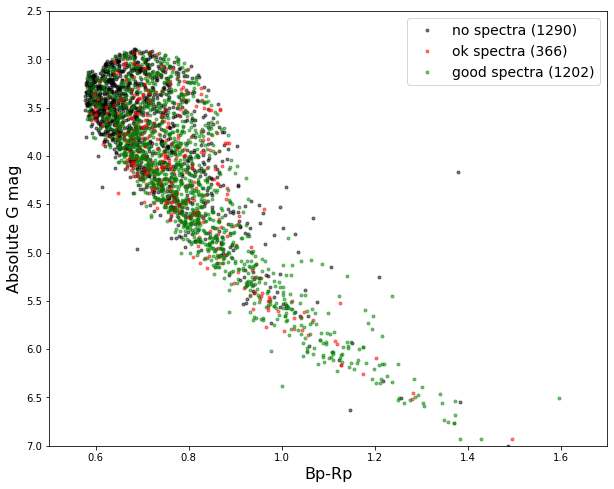

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ms = 6
ax.plot(no_spectra_table['bp_rp'], no_spectra_table['gmag'] + 5.*(np.log10(no_spectra_table['parallax']/1.e3)+1), 
        c='k', alpha=0.5, marker='.', ls='', ms=ms, label='no spectra ({0})'.format(len(no_spectra_table)))
ax.plot(ok_spectra_table['bp_rp'], ok_spectra_table['gmag'] + 5.*(np.log10(ok_spectra_table['parallax']/1.e3)+1), 
        c='r', alpha=0.5, marker='.', ls='', ms=ms, label='ok spectra ({0})'.format(len(ok_spectra_table)))
ax.plot(good_spectra_table['bp_rp'], good_spectra_table['gmag'] + 5.*(np.log10(good_spectra_table['parallax']/1.e3)+1), 
        c='g', alpha=0.5, marker='.', ls='', ms=ms, label='good spectra ({0})'.format(len(good_spectra_table)))
ax.set_ylim([7,2.5])
ax.set_xlim([0.5,1.7])
plt.legend(fontsize=14)
ax.set_xlabel('Bp-Rp', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16);
#plt.savefig('hires_cmag_snr{0}.png'.format(min_snr));

#### HIDES (Takeda et al. 2005):

In [53]:
import os
hides_files = os.listdir('hides/reduced')
hides_hds = [f[1:7].lstrip('0') for f in hides_files]

In [54]:
len(np.unique(hides_hds))

161

In [55]:
table[np.isin(table['hd'], hides_hds) & (table['spectrum_harps'] != 'true') & (table['spectrum_sophie'] != 'true')]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr
,,,,,,,,,,,,,,,,,,,,,,,,,K,K,K,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,,,,,,,,
float64,float64,str29,int64,int64,int64,str29,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,float64,int64,float64,str29,int64,float64,str29,int64,float64
238.1689210400862,42.4515174680292,1 Her,1384195086792268800,1384195086792268800,77760,142373,157364190,15524052+4227052,J155240.95+422712.1,238.17156439238,0.0608,42.45431545672,0.0739,62.9028,0.0807,438.839,0.08,629.541,0.099,4.424265,0.784468,-56.01,0.16,J2016.0,6073.0,5888.5,6158.0,1.6416837,1.5966756,1.7461708,3.3028345,3.2885118,3.3171573,,--,--,--,,--,--,,--,--
191.2475206828197,39.2789161469845,10 CVn,1521686782461765888,1521686782461765888,62207,110897,389853353,12445938+3916441,--,191.24545542461,0.0197,39.27953401499,0.0174,56.9588,0.0323,-359.699,0.018,139.016,0.018,5.803025,0.756415,80.45,0.19,J2016.0,5967.75,5926.5,6026.3335,0.98277783,0.96376306,0.9965062,1.103692,1.1017659,1.1056182,true,102700.0,3,139.7855500400524,,--,--,,--,--
54.2182654350701,0.4016644716193,10 Tau,3263836568393943808,3263836568394170880,16852,22484,649766486,03365238+0024054,J033652.23+002400.9,54.21723179469,0.1306,0.39952459488,0.1093,71.837,0.1503,-232.563,0.164,-481.472,0.143,4.141093,0.757795,nan,nan,J2016.0,6082.3335,5830.0,6164.6665,--,--,--,--,--,--,true,71600.0,2,151.42654985173505,,--,--,,--,--
143.9145924739025,35.8101325142152,11 LMi,798068905726303232,798068905726303232,47080,82885,8915802,09353959+3548366,J093538.92+354834.4,143.91061083593,0.0692,35.80898121341,0.0601,89.0092,0.0937,-726.514,0.07,-259.057,0.062,5.200431,0.934127,14.39,0.17,J2016.0,5661.0,5488.0,6794.75,0.93610704,0.64977777,0.99605566,0.8108086,0.8083409,0.8132763,true,71600.0,1,95.0,,--,--,,--,--
81.1060970084435,17.3835351141963,111 Tau,3400292798990117888,3400292798990117888,25278,35296,47346402,05242545+1723006,J052425.63+172301.0,81.10726354597,0.0837,17.3835033119,0.0574,68.5908,0.104,250.483,0.108,-7.156,0.077,4.850188,0.708018,37.67,0.24,J2016.0,6171.0,6060.0,6327.25,1.1929284,1.1347377,1.23703,1.8592839,1.8510683,1.8674996,,--,--,--,,--,--,,--,--
41.0499442308761,49.2284485192149,13 Per,438829629113960704,438829629114680704,12777,16895,302158903,02441197+4913423,J024412.13+491342.8,41.05222216366,0.1241,49.22805187168,0.1205,89.685,0.1638,334.708,0.182,-89.251,0.161,3.983001,0.692074,25.09,0.66,J2016.0,6282.5,6072.25,6353.25,1.3403078,1.3106226,1.4347303,2.5213537,2.5080245,2.534683,true,71600.0,1,108.0,,--,--,,--,--
242.6013153162529,43.8176409463358,14 Her,1385293808145621504,1385293808145621504,79248,145675,219483057,16102432+4349037,J161024.44+434900.5,242.60212681176,0.0222,43.81632083727,0.0268,55.8657,0.0291,131.745,0.028,-297.025,0.037,6.39524,1.002047,-13.99,0.15,J2016.0,5282.0,5209.3335,5533.0,1.0036839,0.91468686,1.0318806,0.70645136,0.7059177,0.706985,true,71600.0,7,274.238946905796,,--,--,,--,--
79.785314374634,40.0990514113722,15 Aur,188771135583573504,188771135583573504,24813,34411,409104974,05190848+4005565,J051909.51+400547.6,79.78833900873,0.1068,40.09609817128,0.0608,79.6021,0.1005,520.569,0.132,-664.488,0.097,4.525885,0.790791,66.53,0.14,J2016.0,5979.0,5839.0,6157.0,1.2711927,1.1987543,1.3328816,1.8605087,1.8540174,1.867,true,71600.0,7,214.2498541423074,,--,--,,--,--


#### FIES archive:

In [33]:
fies = np.genfromtxt('fies/fies_mortier.log', names=['primary_name','fits_name','mode',
                                             'resolution','exptime','date','name1','idk',
                                             'ra','dec','name2'],
             skip_header=2, invalid_raise=False, dtype=None, encoding=None)

/Users/mbedell/opt/miniconda3/envs/gr8stars/lib/python3.7/site-packages/ipykernel_launcher.py:4: ConversionWarning: Some errors were detected !
    Line #4 (got 1 columns instead of 11)
    Line #5 (got 1 columns instead of 11)
    Line #16 (got 1 columns instead of 11)
    Line #25 (got 1 columns instead of 11)
    Line #36 (got 1 columns instead of 11)
    Line #44 (got 1 columns instead of 11)
    Line #45 (got 1 columns instead of 11)
    Line #47 (got 1 columns instead of 11)
    Line #48 (got 1 columns instead of 11)
    Line #50 (got 1 columns instead of 11)
    Line #51 (got 1 columns instead of 11)
    Line #52 (got 1 columns instead of 11)
    Line #55 (got 1 columns instead of 11)
    Line #58 (got 1 columns instead of 11)
    Line #60 (got 1 columns instead of 11)
    Line #64 (got 1 columns instead of 11)
    Line #67 (got 12 columns instead of 11)
    Line #81 (got 1 columns instead of 11)
    Line #89 (got 1 columns instead of 11)
    Line #97 (got 1 columns instead of 1

In [34]:
fies = Table(fies[fies['resolution'] == 'HiRes'])

In [77]:
fies[fies['primary_name'] == 'HD101177A']

primary_name,fits_name,mode,resolution,exptime,date,name1,idk,ra,dec,name2
str16,str15,str5,str10,float64,str21,str18,str6,float64,float64,str17
HD101177A,FIye070034.fits,F4,HiRes,180.0,2015-05-07T20:51:43,HD101177,None,174.6647469133,45.1217411156,HD101177
HD101177A,FIyg120101.fits,F4,HiRes,300.0,2015-07-12T20:59:43,HIP056809A,None,174.6825180187,45.0899533484,HIP056809A
HD101177A,FIyg120102.fits,F4,HiRes,1500.0,2015-07-12T21:08:05,HIP056809B,None,174.6792936872,45.0888591995,HIP056809B


In [66]:
fies_stars = np.unique(fies['primary_name'])
table_primary_nospaces = np.array([t.replace(" ","") for t in table['primary_name']])

table.add_column(Column(name='spectrum_fies', dtype='<U29', length=len(table)))
table.add_column(Column(name='spectrum_fies_nobs', dtype='int', length=len(table)))
table.add_column(Column(name='spectrum_fies_exptime', length=len(table)))

for f in fies_stars:
    table['spectrum_fies'][table_primary_nospaces == f] = 'true'
    all_fies = fies[fies['primary_name'] == f]
    table['spectrum_fies_nobs'][table_primary_nospaces == f] = len(all_fies)
    table['spectrum_fies_exptime'][table_primary_nospaces == f] = np.sum(all_fies['exptime'])

In [67]:
table

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_fies,spectrum_fies_nobs,spectrum_fies_exptime
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,int64,float64,str4,int64,float64,str4,int64,float64,str29,int64,float64
238.1689210400862,42.4515174680292,1 Her,1384195086792268800,1384195086792268800,77760,142373,157364190,15524052+4227052,J155240.95+422712.1,238.17156439238,0.0608,42.45431545672,0.0739,62.9028,0.0807,438.839,0.08,629.541,0.099,4.424265,0.784468,-56.01,0.16,J2016.0,6073.0,5888.5,6158.0,1.6416836977005005,1.5966756343841553,1.7461707592010498,3.3028345108032227,3.2885117530822754,3.31715726852417,--,--,--,--,--,--,--,--,--,--,,0,0.0
126.1458923835362,-3.7512424989997,1 Hya,3066710282611675776,3066710282611675776,41211,70958,168975758,08243502-0345045,J082434.89-034504.6,126.14494794137,0.045,-3.75135791807,0.032,36.9674,0.061,-212.044,0.06,-25.969,0.059,5.468879,0.648508,96.87,5.64,J2016.0,6320.5,6246.0,6395.0,1.5511353015899658,1.5152051448822021,1.5883586406707764,3.4593920707702637,3.446709156036377,3.4720749855041504,--,--,--,--,--,--,--,--,--,--,,0,0.0
191.2475206828197,39.2789161469845,10 CVn,1521686782461765888,1521686782461765888,62207,110897,389853353,12445938+3916441,--,191.24545542461,0.0197,39.27953401499,0.0174,56.9588,0.0323,-359.699,0.018,139.016,0.018,5.803025,0.756415,80.45,0.19,J2016.0,5967.75,5926.5,6026.33349609375,0.9827778339385986,0.9637630581855774,0.9965062141418457,1.1036920547485352,1.1017658710479736,1.1056182384490967,true,102700.0,3,139.8,--,--,--,--,--,--,,0,0.0
54.2182654350701,0.4016644716193,10 Tau,3263836568393943808,3263836568394170880,16852,22484,649766486,03365238+0024054,J033652.23+002400.9,54.21723179469,0.1306,0.39952459488,0.1093,71.837,0.1503,-232.563,0.164,-481.472,0.143,4.141093,0.757795,nan,nan,J2016.0,6082.33349609375,5830.0,6164.66650390625,--,--,--,--,--,--,true,71600.0,2,151.4,--,--,--,--,--,--,,0,0.0
74.9346751253041,15.9167324100169,101 Tau,3393284752392701312,3393284752392701312,23214,31845,389121767,04594432+1555002,J045944.38+155459.9,74.93506827868,0.0241,15.91660060912,0.0127,22.3771,0.0262,85.068,0.033,-29.655,0.021,6.644502,0.59449,41.72,0.54,J2016.0,6520.25,6444.5,6551.5,1.4123555421829224,1.3989139795303345,1.4457528591156006,3.2481775283813477,3.2326443195343018,3.2637107372283936,--,--,--,--,true,1,123.5,--,--,--,,0,0.0
76.8625232015097,18.6450499366847,104 Tau,3407611182744289152,3407611182744289152,23835,32923,27136704,05072692+1838420,--,76.86503115411,0.0897,18.64513194789,0.0566,62.8252,0.1094,534.674,0.111,18.449,0.083,4.732457,0.844065,20.58,0.15,J2016.0,5835.0,5700.0,6022.0,1.5503768920898438,1.4555847644805908,1.6246854066848755,2.510340929031372,2.4968111515045166,2.5238707065582275,true,71600.0,3,196.4,true,48,597.9,--,--,--,,0,0.0
315.1410034667797,-4.7302596237905,11 Aqr,6912276699251278848,6912276699251278848,103682,199960,248854510,21003382-0443486,J210033.85-044350.1,315.1412210745,0.0209,-4.73087375776,0.0137,36.9971,0.0293,48.795,0.028,-138.18,0.021,6.063653,0.779556,-17.34,0.14,J2016.0,5920.0,5863.0,5967.0,1.3689217567443848,1.347441554069519,1.395668387413025,2.0736658573150635,2.0693469047546387,2.0779848098754883,true,71600.0,1,86.0,true,77,596.6,--,--,--,,0,0.0
143.9145924739025,35.8101325142152,11 LMi,798068905726

In [76]:
has_good_fies = table[(table['spectrum_fies'] == 'true') & (table['spectrum_fies_exptime'] >= 1800.)]
from astropy.io import ascii
ascii.write(has_good_fies, 'targets_with_fies.csv', delimiter=',', formats={'spectrum_hires_snr':'%.1f'},
           comment=False, overwrite=True)

In [78]:
has_good_fies

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_fies,spectrum_fies_nobs,spectrum_fies_exptime
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,int64,float64,str4,int64,float64,str4,int64,float64,str29,int64,float64
295.466552844129,50.517524746342,16 Cyg B,2135550755683407232,2135550755683407232,96901,186427,27533327,19415198+5031032,J194151.82+503102.2,295.46561283744,0.0139,50.5168016497,0.0222,47.3302,0.0171,-134.482,0.018,-162.698,0.027,6.073419,0.82616,-27.73,0.16,J2016.0,5777.25,5696.5,5890.0,1.1198002099990845,1.077338695526123,1.151772379875183,1.2585208415985107,1.2572907209396362,1.2597509622573853,true,71600.0,2,129.4,--,--,--,--,--,--,true,8,2100.0
243.6682808607854,33.8575267185817,17 CrB B,1328866562170960384,1328866562170960384,79607,146361B,17542166,16144043+3351272,--,243.66672417598,0.0115,33.85717773456,0.0152,44.134,0.0179,-290.86,0.015,-78.524,0.021,6.43822,0.781727,-14.79,0.14,J2016.0,5884.75,5859.0,5928.0,0.9749740362167358,0.9607993364334106,0.9835627675056458,1.0270531177520752,1.0260554552078247,1.0280507802963257,true,71600.0,2,120.9,--,--,--,--,--,--,true,10,3500.0
25.6240105213668,20.2685126826973,2 Ari,96331172942614528,96331172942614528,7981,10476,113710966,01422977+2016073,J014229.55+201559.7,25.62258568628,0.1209,20.26551918226,0.0906,130.8234,0.1532,-300.737,0.137,-673.539,0.106,4.99968,1.022485,-33.58,0.17,J2016.0,5489.33349609375,5063.5,6576.0,0.7443567514419556,0.5186766982078552,0.8748200535774231,0.4532475173473358,0.45170915126800537,0.45478588342666626,true,102700.0,5,315.3,--,--,--,--,--,--,true,7,6100.0
9.8408558047264,21.2504758066667,54 Psc,2802397960855105920,2802397960855105920,3093,3651,434210589,00392187+2115024,J003921.43+211457.4,9.83865291546,0.0368,21.24883304645,0.0165,90.0248,0.0482,-461.948,0.068,-369.624,0.025,5.654319,1.018104,-33.0,0.16,J2016.0,5280.0,5158.0,5456.0,0.8785584568977356,0.8227914571762085,0.9206103086471558,0.5404701232910156,0.5398627519607544,0.5410774946212769,true,102700.0,5,308.2,--,--,--,--,--,--,true,14,12435.0
316.7247482895924,38.7494173194371,61 Cyg A,1872046574983507456,1872046609345556480,104214,201091,165602000,21065341+3844529,--,316.748479294,0.0388,38.7638624465,0.0485,285.9949,0.0599,4164.209,0.055,3249.614,0.055,4.766713,1.46259,-65.94,0.14,J2016.0,4327.0,4223.919921875,4427.66015625,0.7201448678970337,0.6877729296684265,0.7557224035263062,0.16378797590732574,0.16338737308979034,0.16418857872486115,true,102700.0,5,342.2,--,--,--,--,--,--,true,4,2100.0
316.7302660185277,38.7420440332954,61 Cyg B,1872046574983497216,1872046574983497216,104217,201092,165602023,21065473+3844265,--,316.75366275256,0.019,38.75607277206,0.0232,286.0054,0.0289,4105.976,0.026,3155.942,0.027,5.450644,1.715341,-64.43,0.13,J2016.0,4177.3046875,3988.0,4725.25,0.5798373818397522,0.4531572759151459,0.6361920237541199,0.09223415702581406,0.09210682660341263,0.09236148744821548,true,102700.0,5,345.7,--,--,--,--,--,--,true,4,2100.0
293.0899592077505,69.6611766125574,61 Dra,2261614264930275072,2261614264931057664,96100,185144,259237827,19322153+6939413,J193222.79+693922.3,293.09759805108,0.0754,69.65345106255,0.0708,173.4939,0.0748,597.384,0.115,-1738.286,0.102,4.449041,0.994315,26.58,0.16,J2016.0,5450.5,5137.0,5924.0,0.7520942687988281,0.636670708656311,

In [74]:
no_good_fies = table[(table['spectrum_fies'] != 'true') | (table['spectrum_fies_exptime'] <= 1800.)]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_fies,spectrum_fies_nobs,spectrum_fies_exptime
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,int64,float64,str4,int64,float64,str4,int64,float64,str29,int64,float64
238.1689210400862,42.4515174680292,1 Her,1384195086792268800,1384195086792268800,77760,142373,157364190,15524052+4227052,J155240.95+422712.1,238.17156439238,0.0608,42.45431545672,0.0739,62.9028,0.0807,438.839,0.08,629.541,0.099,4.424265,0.784468,-56.01,0.16,J2016.0,6073.0,5888.5,6158.0,1.6416836977005005,1.5966756343841553,1.7461707592010498,3.3028345108032227,3.2885117530822754,3.31715726852417,--,--,--,--,--,--,--,--,--,--,,0,0.0
126.1458923835362,-3.7512424989997,1 Hya,3066710282611675776,3066710282611675776,41211,70958,168975758,08243502-0345045,J082434.89-034504.6,126.14494794137,0.045,-3.75135791807,0.032,36.9674,0.061,-212.044,0.06,-25.969,0.059,5.468879,0.648508,96.87,5.64,J2016.0,6320.5,6246.0,6395.0,1.5511353015899658,1.5152051448822021,1.5883586406707764,3.4593920707702637,3.446709156036377,3.4720749855041504,--,--,--,--,--,--,--,--,--,--,,0,0.0
191.2475206828197,39.2789161469845,10 CVn,1521686782461765888,1521686782461765888,62207,110897,389853353,12445938+3916441,--,191.24545542461,0.0197,39.27953401499,0.0174,56.9588,0.0323,-359.699,0.018,139.016,0.018,5.803025,0.756415,80.45,0.19,J2016.0,5967.75,5926.5,6026.33349609375,0.9827778339385986,0.9637630581855774,0.9965062141418457,1.1036920547485352,1.1017658710479736,1.1056182384490967,true,102700.0,3,139.8,--,--,--,--,--,--,,0,0.0
54.2182654350701,0.4016644716193,10 Tau,3263836568393943808,3263836568394170880,16852,22484,649766486,03365238+0024054,J033652.23+002400.9,54.21723179469,0.1306,0.39952459488,0.1093,71.837,0.1503,-232.563,0.164,-481.472,0.143,4.141093,0.757795,nan,nan,J2016.0,6082.33349609375,5830.0,6164.66650390625,--,--,--,--,--,--,true,71600.0,2,151.4,--,--,--,--,--,--,,0,0.0
74.9346751253041,15.9167324100169,101 Tau,3393284752392701312,3393284752392701312,23214,31845,389121767,04594432+1555002,J045944.38+155459.9,74.93506827868,0.0241,15.91660060912,0.0127,22.3771,0.0262,85.068,0.033,-29.655,0.021,6.644502,0.59449,41.72,0.54,J2016.0,6520.25,6444.5,6551.5,1.4123555421829224,1.3989139795303345,1.4457528591156006,3.2481775283813477,3.2326443195343018,3.2637107372283936,--,--,--,--,true,1,123.5,--,--,--,,0,0.0
76.8625232015097,18.6450499366847,104 Tau,3407611182744289152,3407611182744289152,23835,32923,27136704,05072692+1838420,--,76.86503115411,0.0897,18.64513194789,0.0566,62.8252,0.1094,534.674,0.111,18.449,0.083,4.732457,0.844065,20.58,0.15,J2016.0,5835.0,5700.0,6022.0,1.5503768920898438,1.4555847644805908,1.6246854066848755,2.510340929031372,2.4968111515045166,2.5238707065582275,true,71600.0,3,196.4,true,48,597.9,--,--,--,,0,0.0
315.1410034667797,-4.7302596237905,11 Aqr,6912276699251278848,6912276699251278848,103682,199960,248854510,21003382-0443486,J210033.85-044350.1,315.1412210745,0.0209,-4.73087375776,0.0137,36.9971,0.0293,48.795,0.028,-138.18,0.021,6.063653,0.779556,-17.34,0.14,J2016.0,5920.0,5863.0,5967.0,1.3689217567443848,1.347441554069519,1.395668387413025,2.0736658573150635,2.0693469047546387,2.0779848098754883,true,71600.0,1,86.0,true,77,596.6,--,--,--,,0,0.0
143.9145924739025,35.8101325142152,11 LMi,798068905726

In [75]:
table[(table['spectrum_fies'] == 'true')]

ra_j2000,dec_j2000,primary_name,gaiadr2_source_id,gaiaedr3_source_id,hip,hd,tic,2mass,wisea,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,gmag,bp_rp,radial_velocity,radial_velocity_error,ref_epoch,gaia_teff,gaia_teff_lower,gaia_teff_upper,gaia_radius,gaia_radius_lower,gaia_radius_upper,gaia_lum,gaia_lum_lower,gaia_lum_upper,spectrum_hires,spectrum_hires_resolution,spectrum_hires_nobs,spectrum_hires_snr,spectrum_harps,spectrum_harps_nobs,spectrum_harps_snr,spectrum_sophie,spectrum_sophie_nobs,spectrum_sophie_snr,spectrum_fies,spectrum_fies_nobs,spectrum_fies_exptime
float64,float64,str29,int64,int64,int64,str7,int64,str16,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,int64,float64,str4,int64,float64,str4,int64,float64,str29,int64,float64
143.9145924739025,35.8101325142152,11 LMi,798068905726303232,798068905726303232,47080,82885,8915802,09353959+3548366,J093538.92+354834.4,143.91061083593,0.0692,35.80898121341,0.0601,89.0092,0.0937,-726.514,0.07,-259.057,0.062,5.200431,0.934127,14.39,0.17,J2016.0,5661.0,5488.0,6794.75,0.9361070394515991,0.6497777700424194,0.9960556626319885,0.8108085989952087,0.8083409070968628,0.8132762908935547,true,71600.0,1,95.0,--,--,--,--,--,--,true,1,180.0
295.466552844129,50.517524746342,16 Cyg B,2135550755683407232,2135550755683407232,96901,186427,27533327,19415198+5031032,J194151.82+503102.2,295.46561283744,0.0139,50.5168016497,0.0222,47.3302,0.0171,-134.482,0.018,-162.698,0.027,6.073419,0.82616,-27.73,0.16,J2016.0,5777.25,5696.5,5890.0,1.1198002099990845,1.077338695526123,1.151772379875183,1.2585208415985107,1.2572907209396362,1.2597509622573853,true,71600.0,2,129.4,--,--,--,--,--,--,true,8,2100.0
243.6682808607854,33.8575267185817,17 CrB B,1328866562170960384,1328866562170960384,79607,146361B,17542166,16144043+3351272,--,243.66672417598,0.0115,33.85717773456,0.0152,44.134,0.0179,-290.86,0.015,-78.524,0.021,6.43822,0.781727,-14.79,0.14,J2016.0,5884.75,5859.0,5928.0,0.9749740362167358,0.9607993364334106,0.9835627675056458,1.0270531177520752,1.0260554552078247,1.0280507802963257,true,71600.0,2,120.9,--,--,--,--,--,--,true,10,3500.0
25.6240105213668,20.2685126826973,2 Ari,96331172942614528,96331172942614528,7981,10476,113710966,01422977+2016073,J014229.55+201559.7,25.62258568628,0.1209,20.26551918226,0.0906,130.8234,0.1532,-300.737,0.137,-673.539,0.106,4.99968,1.022485,-33.58,0.17,J2016.0,5489.33349609375,5063.5,6576.0,0.7443567514419556,0.5186766982078552,0.8748200535774231,0.4532475173473358,0.45170915126800537,0.45478588342666626,true,102700.0,5,315.3,--,--,--,--,--,--,true,7,6100.0
243.326873802572,13.5269015045144,49 Ser A,4464207428579939840,4464207428579939840,79492,145958A,119985828,16131843+1331379,--,243.32769175625,0.0149,13.52503510048,0.0137,41.1287,0.0197,178.934,0.018,-419.941,0.017,7.181707,0.919627,17.86,0.2,J2016.0,5449.75,5390.0,5524.0,0.8793821334838867,0.8559008240699768,0.8989866971969604,0.6145486831665039,0.6136478781700134,0.6154494881629944,--,--,--,--,--,--,--,--,--,--,true,2,1440.0
243.3267527244158,13.5280454584107,49 Ser B,4464207428577214464,4464207428577214464,79492,145958B,119985831,16131840+1331415,--,243.32764025304,0.0152,13.52616795585,0.0143,41.1545,0.0203,194.154,0.018,-422.438,0.018,7.262869,0.938375,18.51,0.17,J2016.0,5462.66650390625,5405.0,5558.0,0.8402643203735352,0.8116863369941711,0.8582897186279297,0.5664287805557251,0.5656882524490356,0.5671693086624146,--,--,--,--,--,--,--,--,--,--,true,2,1440.0
88.5956723695345,20.276255390142,54 Ori,3399063235753901952,3399063235755057792,27913,39587,114776214,05542300+2016344,J055422.84+201633.3,88.59482419468,0.3168,20.27585214802,0.3124,114.9497,0.528,-179.014,0.405,-90.73,0.337,4.241686,0.796229,-15.48,0.18,J2016.0,6028.33349609375,5947.0,6104.5,1.014517903327942,0.9893593192100525,1.0424575805664062,1.2246252298355103,1